# A1: Data Curation

#### Author: Juan Solorio

We will be recreating *figure 1* by obtaining Wikipedia data from their API for their 'total', 'main site' (*desktop*), and 'mobile site' for data from 2008 to September 2020.

<img src="en-wikipedia_traffic_200712-202010.png">

### Step 1: Gathering the data

First, let's load some libraries we will be using for downloading data (**json, requests**), for data manipulation (**numpy, pandas**), and for creating the final vizualisation (**matplotlib, seaborn**).

In [1]:
import json
import requests
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

Now we need to set some parameter and the endpoints for Wikipedia's API for both the pageviews and pagecounts.

We have 2 endpoints, one for the pageviews and one for the pagecounts, which we will have to do 5 calls for in total. 

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Note that for our project, we're interested in organic (user) traffic, meaning we want to omit the traffic by web crawlers. The Pageview API (but not the Pagecount API) allows you to filter by agent=user, and that is what we will do when setting the parameters for our API json download request. Below we have the 5 request we will submit 2 for pagecounts (desktop and mobile legacy views) and 3 for Pageviews (desktop, mobile web, and mobile app).

In [3]:
# SAMPLE parameters for getting aggregated legacy view data 
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016080100"
                    }


# SAMPLE parameters for getting aggregated current standard pageview data
# see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020100100'
                        }
mobile_web_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020100100'
                        }
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020100100'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/juan-solorio',
    'From': 'juanslr10@gmail.com'
}


Now we can make a function **api_call**, to submit our json requests to the API.

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Now let's do the call request for the Pageviews.

In [5]:
# API Pageview download requests
desktop_monthly_pageviews = api_call(endpoint_pageviews, desktop_params_pageviews)
mobile_web_monthly_pageviews = api_call(endpoint_pageviews, mobile_web_params_pageviews)
mobile_app_monthly_pageviews = api_call(endpoint_pageviews, mobile_app_params_pageviews)

Similarly for the 2 Pagecount requests.

In [6]:
# API Pagecounts requests
desktop_monthly_legacy = api_call(endpoint_legacy, desktop_params_legacy)
mobile_monthly_legacy = api_call(endpoint_legacy, mobile_params_legacy)

Let's do a quick view of one of the requests to make sure we are obtaining the right JSON.
For Pageviews we expect to see something around the lines:

        {
            
            "project": "en.wikipedia",
            
            "access-site": "desktop-site",
            
            "granularity": "monthly",
            
            "timestamp": "2007120100",
            
            "count": 2998331524"
            
        }
                
While for the Pagecounts we expect:

        {
        
            "project": "en.wikipedia",
            
            "access": "mobile-app",
            
            "agent": "user",
            
            "granularity": "monthly",
            
            "timestamp": "2016060100",
            
            "views": 96908466
        
        }

In [11]:
print(desktop_monthly_pageviews)

{'items': [{'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015070100', 'views': 4376666686}, {'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015080100', 'views': 4332482183}, {'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015090100', 'views': 4485491704}, {'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015100100', 'views': 4477532755}, {'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015110100', 'views': 4287720220}, {'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2015120100', 'views': 4100012037}, {'project': 'en.wikipedia', 'access': 'desktop', 'agent': 'user', 'granularity': 'monthly', 'timestamp': '2016010100', 'views': 4436179457}, {'

That seems like what we wanted from the API requests. 

Moving on, we will save the json requests to .json files.

In [12]:
with open('pageviews_desktop-site_201507-202010.json', 'w', encoding='utf-8') as f:
    json.dump(desktop_monthly_pageviews, f, ensure_ascii=False, indent=4)

with open('pageviews_mobile-web_201507-202010.json', 'w', encoding='utf-8') as f:
    json.dump(mobile_web_monthly_pageviews, f, ensure_ascii=False, indent=4)
    
with open('pageviews_mobile-app_201507-202010.json', 'w', encoding='utf-8') as f:
    json.dump(mobile_app_monthly_pageviews, f, ensure_ascii=False, indent=4)
    
with open('pagecounts_desktop-site_200712-202010.json', 'w', encoding='utf-8') as f:
    json.dump(desktop_monthly_legacy, f, ensure_ascii=False, indent=4)
    
with open('pagecounts_mobile-site_200712-202010.json', 'w', encoding='utf-8') as f:
    json.dump(mobile_monthly_legacy, f, ensure_ascii=False, indent=4)

### Step 2: Data Processing
In order to proceed we will have to load up the json data into a format that is easier to do some data wrangling in.

To do our data processing we will be using pandas (and numpy for some data type transformations) by loading the json data
into dataframes. We will also have to call the module json_normalize from pandas to make it easier to convert into the dataframe we want to work with.

In [14]:
pageviews_desktop_site_df = pd.read_json('pageviews_desktop-site_201507-202010.json')
pageviews_mobile_web_df = pd.read_json('pageviews_mobile-web_201507-202010.json')
pageviews_mobile_app_df = pd.read_json('pageviews_mobile-app_201507-202010.json')

pagecounts_desktop_site_df = pd.read_json('pagecounts_desktop-site_200712-202010.json')
pagecounts_mobile_site_df = pd.read_json('pagecounts_mobile-site_200712-202010.json')


# Normalizing the data, extrating from 'items'
pageviews_desktop = json_normalize(pageviews_desktop_site_df['items'])
pageviews_mobile_web = json_normalize(pageviews_mobile_web_df['items'])
pageviews_mobile_app = json_normalize(pageviews_mobile_app_df['items'])

pagecounts_desktop = json_normalize(pagecounts_desktop_site_df['items'])
pagecounts_mobile = json_normalize(pagecounts_mobile_site_df['items'])

/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # Remove the CWD from sys.path while we load stuff.
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/home/juansolo/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.

Now let's take a look at one of the dataframe variables created to make sure we now have a data frame.

In [15]:
pagecounts_desktop.head()

,project,access-site,granularity,timestamp,count
0,en.wikipedia,desktop-site,monthly,2007120100,2998331524
1,en.wikipedia,desktop-site,monthly,2008010100,4930902570
2,en.wikipedia,desktop-site,monthly,2008020100,4818393763
3,en.wikipedia,desktop-site,monthly,2008030100,4955405809
4,en.wikipedia,desktop-site,monthly,2008040100,5159162183


Great so far so good.

Our final data frame that we want to export needs to have the columns **'year', 'month', 'pagecount_all_views',
'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views'**
with the respective values **YYYY, mm, num_views, num_views, num_views, num_views, num_views, num_views**.

If we look at the dataframe above, we need to transform our timestamp column into a format to then split into a **year** and **month** columns.

In [16]:
# using pd.to_datetime to convert to a more manageable format
pageviews_desktop.timestamp = pd.to_datetime(pageviews_desktop.timestamp, format='%Y%m%d%H', errors='coerce')
pageviews_mobile_web.timestamp = pd.to_datetime(pageviews_mobile_web.timestamp, format='%Y%m%d%H', errors='coerce')
pageviews_mobile_app.timestamp = pd.to_datetime(pageviews_mobile_app.timestamp, format='%Y%m%d%H', errors='coerce')

pagecounts_desktop.timestamp = pd.to_datetime(pagecounts_desktop.timestamp, format='%Y%m%d%H', errors='coerce')
pagecounts_mobile.timestamp = pd.to_datetime(pagecounts_mobile.timestamp, format='%Y%m%d%H', errors='coerce')

Now again let's see that we now have a more human readable format for our time stamp after applying *pd.to_datetime*.

In [17]:
pagecounts_mobile.head()

,project,access-site,granularity,timestamp,count
0,en.wikipedia,mobile-site,monthly,2014-10-01,3091546685
1,en.wikipedia,mobile-site,monthly,2014-11-01,3027489668
2,en.wikipedia,mobile-site,monthly,2014-12-01,3278950021
3,en.wikipedia,mobile-site,monthly,2015-01-01,3485302091
4,en.wikipedia,mobile-site,monthly,2015-02-01,3091534479


We will have to merge or join our individual dataframes into one for our final printable CSV file. In order to do this, we also want to change the column **views**/**count** into a more descriptive and individual column for each of the dataframes.

In [20]:
pageviews_desktop.rename(columns={'views':'pageview_desktop_views'}, inplace=True)
pageviews_mobile_web.rename(columns={'views':'pageview_mobile_web_views'}, inplace=True)
pageviews_mobile_app.rename(columns={'views':'pageview_mobile_app_views'}, inplace=True)

pagecounts_desktop.rename(columns={'count':'pagecount_desktop_views'}, inplace=True)
pagecounts_mobile.rename(columns={'count':'pagecount_mobile_views'}, inplace=True)

Again let's check that our changes we made are looking the way we want by printing one of the dataframes.

In [21]:
pageviews_desktop.head()

,project,access,agent,granularity,timestamp,pageview_desktop_views
0,en.wikipedia,desktop,user,monthly,2015-07-01,4376666686
1,en.wikipedia,desktop,user,monthly,2015-08-01,4332482183
2,en.wikipedia,desktop,user,monthly,2015-09-01,4485491704
3,en.wikipedia,desktop,user,monthly,2015-10-01,4477532755
4,en.wikipedia,desktop,user,monthly,2015-11-01,4287720220


Ok now it's time for use to start merging the dataframes into the one we want with each of the individual views.

In [22]:
wikidata = pd.merge(pageviews_desktop[['timestamp','pageview_desktop_views']], 
                    pageviews_mobile_web[['timestamp','pageview_mobile_web_views']], on='timestamp', how='outer')
wikidata = pd.merge(wikidata, pageviews_mobile_app[['timestamp','pageview_mobile_app_views']], on='timestamp', how='outer')
wikidata = pd.merge(wikidata, pagecounts_desktop[['timestamp','pagecount_desktop_views']], on='timestamp', how='outer')
wikidata = pd.merge(wikidata, pagecounts_mobile[['timestamp','pagecount_mobile_views']], on='timestamp', how='outer')

# making sure we start from the earliest date in 2007 to the latest in 2020
wikidata = wikidata.sort_values(['timestamp'], ascending = True)

So let's make sure the changes took place

In [23]:
wikidata.head()

,timestamp,pageview_desktop_views,pageview_mobile_web_views,pageview_mobile_app_views,pagecount_desktop_views,pagecount_mobile_views
63,2007-12-01,NaN,NaN,NaN,2.998332e+09,NaN
64,2008-01-01,NaN,NaN,NaN,4.930903e+09,NaN
65,2008-02-01,NaN,NaN,NaN,4.818394e+09,NaN
66,2008-03-01,NaN,NaN,NaN,4.955406e+09,NaN
67,2008-04-01,NaN,NaN,NaN,5.159162e+09,NaN


Great but we can see there are quite a few NaN values in each of the value columns. Let's do a quick count of how many NaN values are in each of the columns.

In [24]:
wikidata.isna().sum()

timestamp                      0
pageview_desktop_views        91
pageview_mobile_web_views     91
pageview_mobile_app_views     91
pagecount_desktop_views       50
pagecount_mobile_views       132
dtype: int64

That is an easy fix, we can use the *replace* function in pandas to change NaN values for 0s.

In [25]:
wikidata = wikidata.replace(np.nan,0)

Ok now let's make the **year** and **month** columns by splitting the timestamp column.

In [26]:
wikidata['year'] = pd.DatetimeIndex(wikidata.timestamp).year
wikidata['month'] = pd.DatetimeIndex(wikidata.timestamp).month

Let's due another check to make sure we have 0s instead of NaNs and that we have our new columns.

In [27]:
wikidata.head()

,timestamp,pageview_desktop_views,pageview_mobile_web_views,pageview_mobile_app_views,pagecount_desktop_views,pagecount_mobile_views,year,month
63,2007-12-01,0.0,0.0,0.0,2.998332e+09,0.0,2007,12
64,2008-01-01,0.0,0.0,0.0,4.930903e+09,0.0,2008,1
65,2008-02-01,0.0,0.0,0.0,4.818394e+09,0.0,2008,2
66,2008-03-01,0.0,0.0,0.0,4.955406e+09,0.0,2008,3
67,2008-04-01,0.0,0.0,0.0,5.159162e+09,0.0,2008,4


Now we need to create the commulitative sum columns for the views. These wil be for all views, all desktop views, and all mobile views.

In [28]:
wikidata['pagecount_all_views'] = wikidata.pagecount_desktop_views + wikidata.pagecount_mobile_views
wikidata['pageview_mobile_views'] = wikidata.pageview_mobile_web_views + wikidata.pageview_mobile_app_views
wikidata['pageview_all_views'] = wikidata.pageview_desktop_views + wikidata.pageview_mobile_views

Ok now let's keep the columns we want and then print this to a csv file labeled 'en-wikipedia_traffic_200712-202010.csv'

In [29]:
wikipedia_df = wikidata[['timestamp', 'year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
                        'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [30]:
wikipedia_df.to_csv('en-wikipedia_traffic_200712-202010.csv')

### Step 3: Analyze the data

Great no we reached the final step where we will recreate the data vizual from *figure 1*.

Let's try this 2 ways just for practive. We will do this through the use of **seaborn** and **matplotlib**.

#### Seaborn Viz

We need to first create a dataframe that will make it easy to manage in seaborn for our time series plots.
For this we need to pivot the *wikidata* dataframe we already had into one with an index (the timestamp), a labels column, and a values column. This will then make it easy for seaborn to read the data and create the line plots for each of the label series.

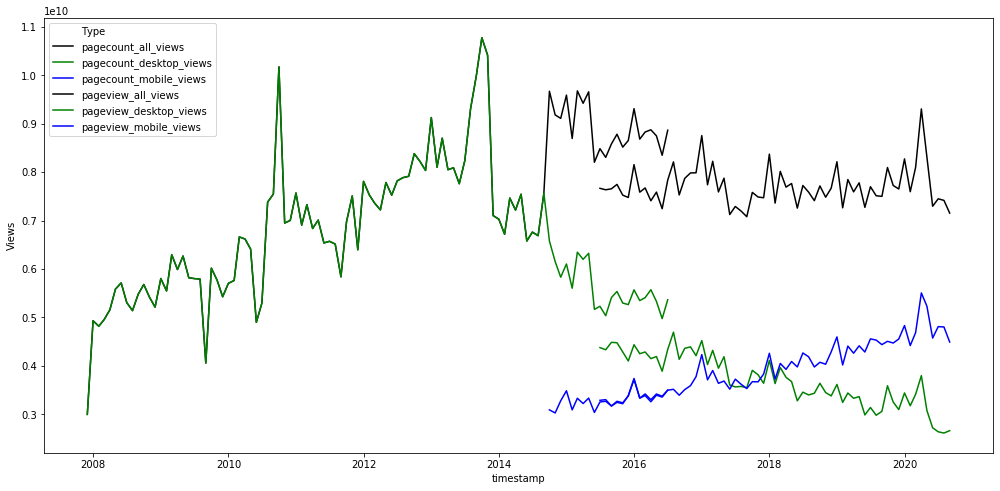

In [31]:
viz_df = pd.melt(wikidata[['timestamp', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
                        'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']], 
        id_vars='timestamp', var_name='Type', value_name='Views')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(17, 8)

palette ={"pagecount_all_views": "k", "pageview_all_views": "k",
          "pagecount_desktop_views": "g", "pageview_desktop_views": "g",
          "pagecount_mobile_views" : "b", "pageview_mobile_views" : "b"}
sns.lineplot(x='timestamp', y='Views',hue='Type', data=viz_df.replace(0,np.nan),dashes=True, palette=palette)


The vizualisation was close, but still not entirely what we were looking for if we wanted to recreate *figure 1*. Let's now do this in **matplotlib** which will likely give us a little more space to work around and get the figure just how we want.


### Matplotlib Viz

We will keep the data as stand in the *wikidata* dataframe and just plot each individual series to get the chart looking like the one in *figure 1*. We will have to adjust the Values by dividing by 1,000,000 to make the labels better on the vertical axis as well as adjusting the labels for the 'desktop', 'mobile', and 'all' series to match accordingly.

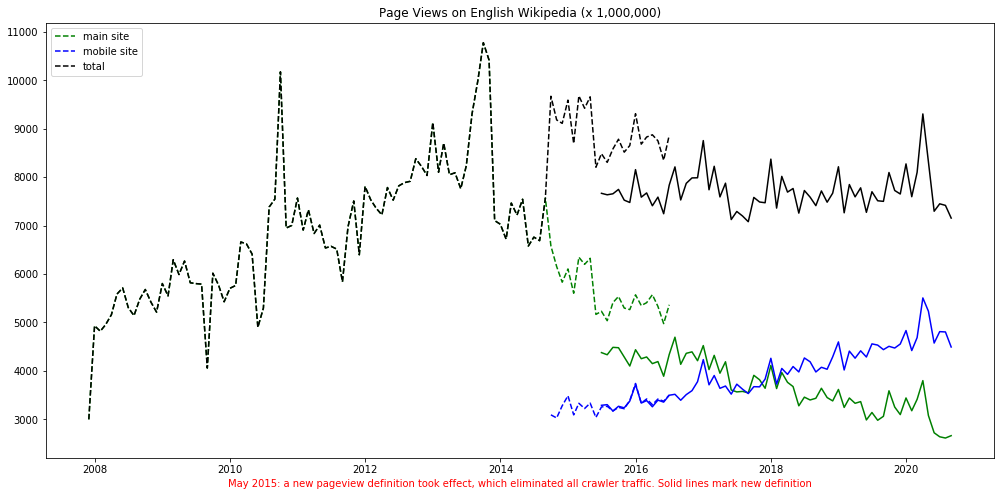

In [32]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(17, 8)
plt.plot(wikidata.timestamp, wikidata.pagecount_desktop_views.replace(0,np.nan)/1000000, '--g',label='main site')
plt.plot(wikidata.timestamp, wikidata.pagecount_mobile_views.replace(0,np.nan)/1000000, '--b',label='mobile site')
plt.plot(wikidata.timestamp, wikidata.pagecount_all_views.replace(0,np.nan)/1000000, '--k',label='total')
plt.plot(wikidata.timestamp, wikidata.pageview_desktop_views.replace(0,np.nan)/1000000, '-g')
plt.plot(wikidata.timestamp, wikidata.pageview_mobile_views.replace(0,np.nan)/1000000, '-b')
plt.plot(wikidata.timestamp, wikidata.pageview_all_views.replace(0,np.nan)/1000000, '-k')
plt.legend(loc='upper left')

plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.xlabel('May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition')
ax.xaxis.label.set_color('red')
plt.show()


Great and now we have accomplish our goal.